In [200]:
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import onnxruntime as ort
import matplotlib.pyplot as plt

from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB

from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence


from helpers import get_data, process_data, display_data

In [201]:
def map_label_to_class(label):
  topic_to_index = {
    "tech" : 0,
    "sport" : 1,
    "politics" : 2,
    "gaming" : 3,
    "food" : 4,
    "business" : 5
  }

  try: 
    return topic_to_index[label]
  except: raise ValueError(f"Label '{label}' not found in any source categories.")

def pytorch_to_numpy(loader):
  inputs_array = []
  labels_array = []
  for inputs, labels in loader:
    inputs_batch = inputs.cpu().numpy()
    labels_batch = labels.cpu().numpy()

    for input in inputs_batch:
      inputs_array.append(input)
    for label in labels_batch:
      labels_array.append(label)
  return inputs_array, labels_array

In [202]:
# dataset initialization
class TopicData(Dataset):
  def __init__(self,df,device):
    df.drop(columns=['id'])
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    self.data = df
    self.device = device
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    text = self.data['text'][idx]
    label = map_label_to_class(self.data['topic'][idx])
    vectorized_text = self.tokenizer(
      text,
      return_tensors='pt',
      truncation=True,
      padding='max_length'
      )
    input = vectorized_text['input_ids'].squeeze(0)
    return input.to(self.device),torch.tensor(label).to(self.device)

In [203]:
# split data 
def collate_fn(batch):
  inputs, labels = zip(*batch)
  inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
  labels = torch.stack(labels)
  return inputs, labels

def split_data(dataset,batch_size):
  train_idx, test_idx = train_test_split(range(len(dataset)),test_size=0.2,random_state=42,shuffle=True)
  train_dataset = Subset(dataset,train_idx)
  test_dataset = Subset(dataset,test_idx)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  return train_loader, test_loader

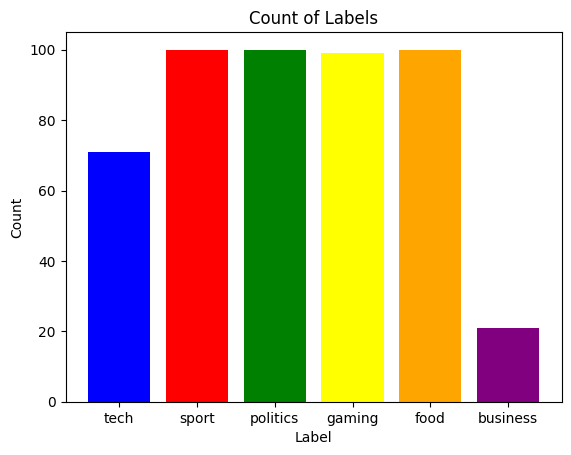

cuda
[5 5 5 5 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 5 1 5
 5 5 5 5 5 5 5 0 5 5 5 5 5 5 5 2 5 0 5 5 5 5 5 5 5 5 5 5 5 1 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 2 5 5 5 5 5 5 5 5 5 2 5 5 5 5 5 5]
Number of mislabeled points out of a total 99 points : 73


In [ ]:
def main(text, batch_size, num_epochs, verbose, override, skl):
  device = ('cuda' if torch.cuda.is_available() else 'cpu')

  nn_path = '../models/'
  
  df = get_data()
  df = process_data(df)

  if (override or not os.path.exists(nn_path) and verbose):
    display_data(df)
    print(device)

  if skl: batch_size = len(df)

  dataset = TopicData(df,device)
  train_loader, test_loader = split_data(dataset,batch_size)

  inputs_array, labels_array = pytorch_to_numpy(train_loader)
  test_inputs_array, test_label_array = pytorch_to_numpy(test_loader)

  gnb = GaussianNB()
  model = gnb.fit(inputs_array,labels_array)
  pred = model.predict(test_inputs_array)
  print("Number of mislabeled points out of a total %d points : %d"
      % (len(test_inputs_array), (test_label_array != pred).sum()))
  #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
main('sports sports sports', batch_size=1, num_epochs=10, verbose=True, override=True, skl=True)